In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
class Polynomial_Regression():
  #Adding polynomial features
  def Add_Polynomial_Features(self,X,degrees):
    self.A=X
    X1=np.copy(self.A)
    for j in range(2,degrees+1):
      n=X1.shape[1]
      self.add(j,n,X1)
    return self.A

  #Recursion function that helps to add the features
  def add(self,sum,no_elements,X1,i=0,arr=None):
    if not arr:
        arr =[0]*no_elements  
    if sum<0:
        return
    if i==no_elements:
        if sum==0:
          M=X1**arr
          p=np.ones((X1.shape[0],1))
          for k in range(X1.shape[1]):
            p*=(M[:,k].reshape(-1,1))
            p=p.reshape(-1,1)
          self.A=np.append(self.A,p,axis=1)
        return
    for val in range(0,sum+1):
        arr[i] = val
        self.add(sum-val,no_elements,X1,i+1,arr)
  
  def train_dev_split(self,X,Y,train_size):
    m_=int(train_size*X.shape[0])
    X_train=X[:m_,:]
    X_dev=X[m_:,:]
    Y_train=Y[:m_]
    Y_dev=Y[m_:] 
    return X_train,Y_train,X_dev,Y_dev

  #Z score normalization
  def Z_score_standardize(self,X,X_train_):
    Mean=np.mean(X_train_,axis=0)
    std=np.std(X_train_,axis=0)
    std[std==0]=1
    return (X-Mean)/std

  def min_max_normalize(self,X,X_train_):
    Min=np.min(X_train_,axis=0)
    Max=np.max(X_train_,axis=0)
    Range=Max-Min
    Range[Range==0]=1
    return (X-Min)/Range

  
  #Batch gradient descent
  def Batch_GD(self,X_train,Y_train,iterations=7,learning_rate=0.6,L2_regularization_term=0,Exp_learning_rate_decay=None,Feature_Scaling="Z_score_standardization",validation=False,X_dev=np.array([]),Y_dev=np.array([])): 
    alpha=learning_rate
    alpha1=alpha
    lamda=L2_regularization_term
    self.iterations=iterations
    self.validation=validation
    self.Y_train=Y_train.reshape(-1,1)
    self.X_train_=np.copy(X_train)  
    if Feature_Scaling=="Z_score_standardization":
      self.X_train_n=self.Z_score_standardize(X_train,self.X_train_)
    elif Feature_Scaling=="min_max_normalization":
      self.X_train_n=self.min_max_normalize(X_train,self.X_train_)
    else:
      self.X_train_n=X_train
    m_train,n_train=self.X_train_n.shape  
    self.w=np.random.randn(n_train,1)  
    self.b=np.random.randn()  
    self.J_train_list=[] 
    self.R2_train_list=[]
    if self.validation:
      if X_dev.size>0 and Y_dev.size>0:
        self.X_dev_=np.copy(X_dev)
        self.J_dev_list=[]
        self.R2_dev_list=[]
        self.Y_dev=Y_dev.reshape(-1,1)
        if Feature_Scaling=="Z_score_standardization":
          self.X_dev_n=self.Z_score_standardize(X_dev,self.X_train_)
        elif Feature_Scaling=="min_max_normalization":
          self.X_dev_n=self.min_max_normalize(X_dev,self.X_train_)
        else:
          self.X_dev_n=X_dev
      else:
        print("Please give dev data in function call" )
        return 

    for i in range(self.iterations):
      Y_pred_train=self.predict(self.X_train_n)
      self.J_train_list.append(self.MSE(self.Y_train,Y_pred_train))
      self.R2_train_list.append(self.R2(self.Y_train,Y_pred_train))
      if self.validation:
        Y_pred_dev=self.predict(self.X_dev_n)
        self.J_dev_list.append(self.MSE(self.Y_dev,Y_pred_dev))
        self.R2_dev_list.append(self.R2(self.Y_dev,Y_pred_dev))
      dJ_dw=(1/m_train)*(self.X_train_n.T@(Y_pred_train-self.Y_train))+((lamda/m_train)*self.w)
      dJ_db=(1/m_train)*(np.sum(Y_pred_train-self.Y_train))
      self.w -= alpha*dJ_dw
      self.b -= alpha*dJ_db     
      if Exp_learning_rate_decay:
        alpha=((Exp_learning_rate_decay)**i)*alpha1

    Y_pred_train=self.predict(self.X_train_n)
    self.J_train_list.append(self.MSE(self.Y_train,Y_pred_train))
    self.R2_train_list.append(self.R2(self.Y_train,Y_pred_train))
    if self.validation:
      Y_pred_dev=self.predict(self.X_dev_n)
      self.J_dev_list.append(self.MSE(self.Y_dev,Y_pred_dev))
      self.R2_dev_list.append(self.R2(self.Y_dev,Y_pred_dev))
  
  def mini_batch_GD(self,X_train,Y_train,epochs=7,learning_rate=0.6,L2_regularization_term=0,Exp_learning_rate_decay=None,mini_batch_size=100,Feature_Scaling="Z_score_standardization",validation=False,X_dev=np.array([]),Y_dev=np.array([])):
    self.mini_batch_size=mini_batch_size
    self.alpha=learning_rate
    alpha1=self.alpha
    self.lamda=L2_regularization_term
    self.iterations=epochs
    self.validation=validation
    self.Y_train=Y_train.reshape(-1,1)
    self.X_train_=np.copy(X_train)  
    self.n=X_train.shape[1]
    self.mini_batch_size=mini_batch_size
    if Feature_Scaling=="Z_score_standardization":
      self.X_train_n=self.Z_score_standardize(X_train,self.X_train_)
    elif Feature_Scaling=="min_max_normalization":
      self.X_train_n=self.min_max_normalize(X_train,self.X_train_)
    else:
      self.X_train_n=X_train
    m_train,n_train=self.X_train_n.shape  
    self.w=np.random.randn(n_train,1)  
    self.b=np.random.randn()  
    self.J_train_list=[] 
    self.R2_train_list=[]
    if self.validation:
      if X_dev.size>0 and Y_dev.size>0:
        self.X_dev_=np.copy(X_dev)
        self.J_dev_list=[]
        self.R2_dev_list=[]
        self.Y_dev=Y_dev.reshape(-1,1)
        if Feature_Scaling=="Z_score_standardization":
          self.X_dev_n=self.Z_score_standardize(X_dev,self.X_train_)
        elif Feature_Scaling=="min_max_normalization":
          self.X_dev_n=self.min_max_normalize(X_dev,self.X_train_)
        else:
          self.X_dev_n=X_dev
      else:
        print("Please give dev data in function call" )
        return
    train_data=np.append(self.X_train_n,self.Y_train,axis=1)

    for i in range(epochs):
      Y_pred_train=self.predict(self.X_train_n)
      self.J_train_list.append(self.MSE(self.Y_train,Y_pred_train))
      self.R2_train_list.append(self.R2(self.Y_train,Y_pred_train))
      if self.validation:
        Y_pred_dev=self.predict(self.X_dev_n)
        self.J_dev_list.append(self.MSE(self.Y_dev,Y_pred_dev))
        self.R2_dev_list.append(self.R2(self.Y_dev,Y_pred_dev))
      np.random.shuffle(train_data)
      mini_batch_list=[train_data[k:k+mini_batch_size,:] for k in range(0,m_train,mini_batch_size)]
      for mini_batch in mini_batch_list:
        self.update(mini_batch)
        
    if Exp_learning_rate_decay:
      self.alpha=(Exp_learning_rate_decay**i)*alpha1
      
    Y_pred_train=self.predict(self.X_train_n)
    self.J_train_list.append(self.MSE(self.Y_train,Y_pred_train))
    self.R2_train_list.append(self.R2(self.Y_train,Y_pred_train))
    if self.validation:
      Y_pred_dev=self.predict(self.X_dev_n)
      self.J_dev_list.append(self.MSE(self.Y_dev,Y_pred_dev))
      self.R2_dev_list.append(self.R2(self.Y_dev,Y_pred_dev))

  def update(self,mini_batch):
    x=mini_batch[:,:self.n]
    y=mini_batch[:,self.n:]
    y_pred=self.predict(x)
    dw=(1/self.mini_batch_size)*((x.T)@(y_pred-y))+((self.lamda/self.mini_batch_size)*self.w)
    db=(1/self.mini_batch_size)*(np.sum(y_pred-y))
    self.w-=(self.alpha*dw)
    self.b-=(self.alpha*db)  

  #Printing some results   
  def Results(self,MSE_learning_curve=True,R2_learning_curve=True,Single_feature_vs_label=True,Table_showing_predicted_vs_actual=True):
    li=np.arange(0,self.iterations+1)
    if MSE_learning_curve:
      print("Final MSE of training data is: ",self.J_train_list[-1],"\n")
      if self.validation:
        print("Final MSE of dev data is: ",self.J_dev_list[-1],"\n")
      plt.plot(li,self.J_train_list,color="blue",label="Training Cost")
      if self.validation:
        plt.plot(li,self.J_dev_list,color="Red",label="Dev cost")
      plt.xlabel("Iterations")
      plt.ylabel("Cost")
      plt.title("Cost vs Iterations curve")
      plt.legend()
      plt.show()
      print("\n")
   
    if R2_learning_curve:
      print("Final R2 of training data is: ",self.R2_train_list[-1])
      print("\n")
      if self.validation:
        print("Final R2 of dev data is: ",self.R2_dev_list[-1])
        print("\n")
      plt.plot(li,self.R2_train_list,color="blue",label="Train")
      if self.validation:
        plt.plot(li,self.R2_dev_list,color="Red",label="Dev")
      plt.xlabel("Iterations")
      plt.ylabel("R2")
      plt.title("R2 vs Iterations curve")
      plt.legend()
      plt.show()
      print("\n")
    
    if Single_feature_vs_label:
      plt.scatter(self.X_train_[:20,0],self.predict(self.X_train_n)[:20,:],color="blue",label="Predicted")
      plt.scatter(self.X_train_[:20,0],self.Y_train[:20,:],color="red",label="Actual")
      plt.xlabel("Iterations")
      plt.ylabel("Label")
      plt.title("Actual and predicted value of training set vs a single label for first 20 examples")
      plt.legend()
      plt.show()
      print("\n")

      if self.validation:
        plt.scatter(self.X_dev_[:20,0],self.predict(self.X_dev_n)[:20,:],color="blue",label="Predicted")
        plt.scatter(self.X_dev_[:20,0],self.Y_dev[:20,:],color="red",label="Actual")
        plt.xlabel("Iterations")
        plt.ylabel("Label")
        plt.title("Actual and predicted value of dev set vs a single label for first 20 examples")
        plt.legend()
        plt.show()
        print("\n")

    if Table_showing_predicted_vs_actual:
      train_table=np.append(self.Y_train[:20,:],self.predict(self.X_train_n)[:20,:],axis=1)
      df=pd.DataFrame(train_table,columns=["Actual","Predicted"])
      print("A table showing predicted labels and actual label for the first 20 examples of training data: ")
      print(df)
      print("\n")

      if self.validation:
        train_table=np.append(self.Y_dev[:20,:],self.predict(self.X_dev_n)[:20,:],axis=1)
        df=pd.DataFrame(train_table,columns=["Actual","Predicted"])
        print("A table showing predicted labels and actual label for the first 20 examples of dev data: ")
        print(df)


    
  #predicting values
  def predict(self,X,normalized=True):
    if normalized:
      return (X@self.w+self.b)
    else:
      X=self.normalized(X,self.X_train_)
      return (X@self.w+self.b)

  #Calculation mean squared errors
  def MSE(self,Y,Y_pred):
    Y=Y.reshape(-1,1)
    Y_pred=Y_pred.reshape(-1,1)
    return (1/(2*Y.shape[0]))*(np.sum(np.square(Y_pred-Y)))    

  #R2 calculation
  def R2(self,Y,Y_pred):
    Y=Y.reshape(-1,1)
    Y_pred=Y_pred.reshape(-1,1)
    R2_calc=1-((self.MSE(Y,Y_pred)*2*Y.shape[0])/np.sum(np.square(Y_pred-Y.mean())))
    return R2_calc

Final MSE of training data is:  260548.0325991408 

Final MSE of dev data is:  382152.7339988667 



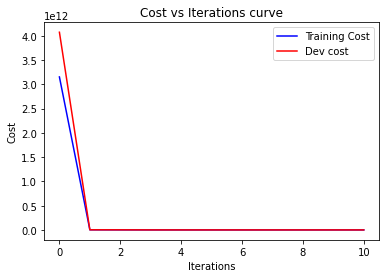



Final R2 of training data is:  0.9999999173857574


Final R2 of dev data is:  0.9999999062059958




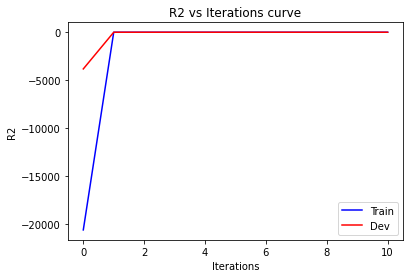

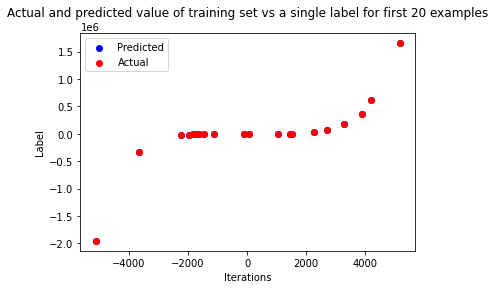

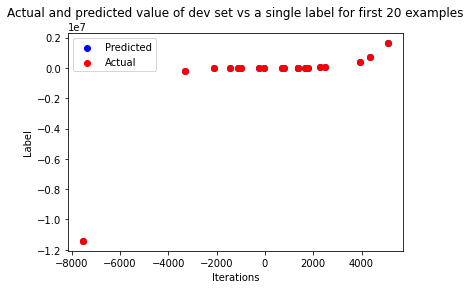



A table showing predicted labels and actual label for the first 20 examples of training data: 
          Actual     Predicted
0  -1.294289e+03 -1.234756e+03
1  -2.714687e+04 -2.719006e+04
2   6.474300e+04  6.480965e+04
3  -7.349871e+03 -7.482883e+03
4   1.651328e+06  1.652290e+06
5  -7.752982e-03  6.782707e+00
6  -3.844969e+03 -4.051323e+03
7   3.700918e+05  3.702678e+05
8  -7.145428e-01 -2.225594e+02
9   2.636708e+04  2.649184e+04
10  1.771588e+05  1.769488e+05
11 -9.927208e+03 -9.969140e+03
12  6.246051e+05  6.254079e+05
13 -9.134990e+03 -9.023752e+03
14 -1.954778e+06 -1.954601e+06
15 -3.241245e+05 -3.240336e+05
16  3.598444e+03  3.478589e+03
17  5.167277e+02  7.111267e+02
18 -1.583688e+04 -1.564921e+04
19  2.847191e+03  2.714329e+03


A table showing predicted labels and actual label for the first 20 examples of dev data: 
          Actual     Predicted
0   3.316465e+04  3.414848e+04
1  -7.106715e+02 -1.183111e+03
2   3.638931e+03  3.030737e+03
3   6.883347e+05  6.886529e+05
4   1

In [ ]:
Model=Polynomial_Regression()
df_arr=np.array(pd.read_csv("/content/drive/MyDrive/Woc/polynomial_train.csv"))
X=df_arr[:,1:-1]
Y=df_arr[:,-1].reshape(-1,1)
X=Model.Add_Polynomial_Features(X,5)
X_train,Y_train,X_dev,Y_dev=Model.train_dev_split(X,Y,0.8)
Model.mini_batch_GD(X_train,Y_train,epochs=10,learning_rate=0.8,L2_regularization_term=0,Exp_learning_rate_decay=None,mini_batch_size=100,Feature_Scaling="Z_score_standardization",validation=True,X_dev=X_dev,Y_dev=Y_dev)
Model.Results()

In [ ]:
0.97**500

2.431460020979148e-07